/root/miniconda3/lib/python3.10/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/root/miniconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/root/miniconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/root/miniconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


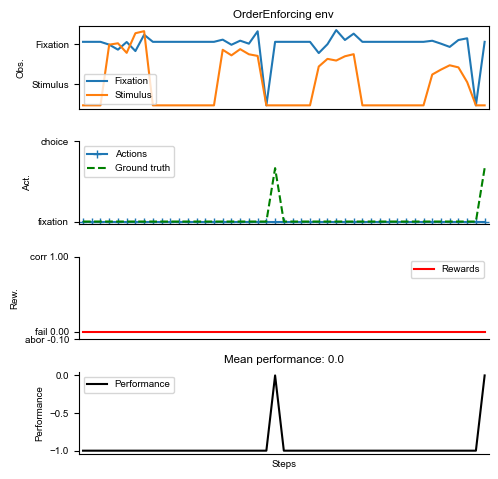

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.nn import init

import gym
import neurogym as ngym

# 利用neurogym构建实验环境
# 这个DelayComparision范式来自于1999年的一篇Nature文章
# Romo, R., Brody, C. D., Hernández, A., & Lemus, L. (1999). Nature, 399(6735), 470–473. doi:10.1038/20939
# 在这个实验中，猴子的一只手的手指需要感受来自机械探头的震动
# 猴子一只手的手指接触机械探头，另一只手需要放在一个固定的按键上
# 然后产生一个频率a的震动刺激1（500ms），
# 经过一段时间的delay之后，产生一个频率b的震动刺激2(500ms)
# 刺激2结束后放在固定按键上的手需要释放，然后进行2选1的按键按压
# 选择刺激1和刺激2哪个刺激震动频率更高
# neurogym内置了DelayComparison任务，只需要设定一些参数即可生成
task = 'DelayComparison-v0'
# 设定实验任务相关条件
# delay时长为200ms或400ms或800ms或1600ms或3200ms
# 固定的反应时长为500ms
# 一个时间点对应100ms
# 序列长度为100个时间点（即10000ms）
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)
         }
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# 构建任务数据集，传入上述相关参数
# batch_size=16代表生成16个序列
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# 获取数据集的环境信息
env = dataset.env

# 可视化该环境下的两个试次
ngym.utils.plot_env(env, num_trials=2, def_act=0, ob_traces=["Fixation", "Stimulus"])
# 首先是Obs.图，表示被试对特定环境的观测值，这里包含两个维度- Stimulus和Fixation
# 其中由于第二个刺激呈现后猴子需要释放按键，所以每次第二个刺激呈现后，Fixation值都会降为0又重新上升
# Act.图中设定了def_act=0即默认不动，而Ground Truth代表实际应该进行的反应（即正确的反应）
# 即每次释放按键后的判断阶段都需要一个反应选择
# 此实验中无设置奖励条件，因而Rew.图不变
# Performance图表示每个试次的表现

# 网络输入和输出的size
# 在gym里，observation_space由Space.Box类表示，action_space由Space.Discrete类表示
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
# input_size为2，output_size为3

In [2]:
def get_modelpath(envid):
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    return path


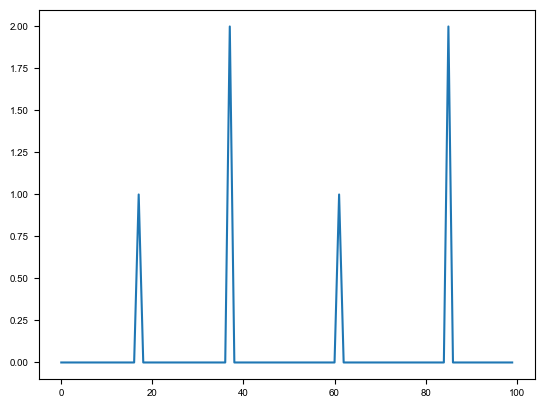

In [3]:
modelpath = get_modelpath(task)
# 获取数据集的inputs和target
inputs, target = dataset()
mask = target > 0
# shape of inputs: N_time * batch_size * N_neuron
#                  即[100, 16, 2]
#                  这里的2，第一个维度为fixation，第二个维度为stimulus
# shape of target: N_time*batch_size
#                  即[100, 16]
# target即为反应（choice），0、1、2分别代表不反应、刺激1频率更高或刺激2频率更高
# 可视化第一个序列的反应
plt.plot(target[:, 0])


In [4]:
import torch
import torch.nn as nn

class LeakyRNN(nn.Module):
    """
    Leaky RNN（泄漏递归神经网络）。

    参数:
        input_size: 输入神经元数量。
        hidden_size: 隐藏神经元数量。
        dt: 离散化时间步（单位：ms）。
            如果为 None，则 `dt` 默认为时间常数 tau。

    输入:
        input: 形状为 (seq_len, batch, input_size) 的张量，表示输入序列。
        hidden: 形状为 (batch, hidden_size) 的张量，初始隐藏状态。
            如果为 None，则通过 self.init_hidden() 初始化。

    输出:
        output: 形状为 (seq_len, batch, hidden_size) 的张量，表示隐藏层的输出序列。
        hidden: 形状为 (batch, hidden_size) 的张量，表示最终隐藏状态。
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size  # 输入特征数量
        self.hidden_size = hidden_size  # 隐藏层神经元数量
        self.tau = 100  # 时间常数
        if dt is None:
            alpha = 1  # 如果未指定 dt，则步长比例为 1
        else:
            alpha = dt / self.tau  # 计算步长比例
        self.alpha = alpha  # 存储步长比例

        self.input2h = nn.Linear(input_size, hidden_size)  # 输入到隐藏层的线性映射
        self.h2h = nn.Linear(hidden_size, hidden_size)  # 隐藏层到隐藏层的线性映射

    def init_hidden(self, input_shape):
        """
        初始化隐藏状态。

        参数:
            input_shape: 输入张量的形状。

        返回:
            初始化为零的隐藏状态张量，形状为 (batch_size, hidden_size)。
        """
        batch_size = input_shape[1]  # 从输入形状中获取批量大小
        return torch.zeros(batch_size, self.hidden_size)  # 初始化为全零张量

    def recurrence(self, input, hidden):
        """
        执行一次时间步的网络更新。

        参数:
            input: 形状为 (batch, input_size) 的张量，表示当前时间步的输入。
            hidden: 形状为 (batch, hidden_size) 的张量，表示当前时间步的隐藏状态。

        返回:
            h_new: 形状为 (batch, hidden_size) 的张量，表示下一时间步的隐藏状态。
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))  # 当前时间步的隐藏状态
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha  # 添加泄漏动态
        return h_new

    def forward(self, input, hidden=None):
        """
        通过网络传播输入。

        参数:
            input: 形状为 (seq_len, batch, input_size) 的张量，输入序列。
            hidden: 初始隐藏状态。

        返回:
            output: 形状为 (seq_len, batch, hidden_size) 的张量，隐藏层的输出序列。
            hidden: 形状为 (batch, hidden_size) 的张量，最终隐藏状态。
        """
        # 如果未提供隐藏状态，则初始化
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []  # 用于存储每个时间步的隐藏层输出
        steps = range(input.size(0))  # 获取时间步数
        for i in steps:
            hidden = self.recurrence(input[i], hidden)  # 更新隐藏状态
            output.append(hidden)  # 保存当前时间步的隐藏状态

        # 将所有时间步的输出堆叠为张量
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """
    带输出层的递归网络模型。

    参数:
        input_size: int, 输入大小。
        hidden_size: int, 隐藏层大小。
        output_size: int, 输出大小。

    输入:
        x: 形状为 (seq_len, batch, input_size) 的输入序列。

    输出:
        out: 形状为 (seq_len, batch, output_size) 的张量，表示最终的网络输出。
        rnn_output: 形状为 (seq_len, batch, hidden_size) 的张量，表示隐藏层的输出序列。
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # 使用 Leaky RNN 作为基础递归网络
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # 输出层，用于从隐藏层映射到输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)  # 获取隐藏层输出序列
        out = self.fc(rnn_output)  # 将隐藏层输出映射到最终输出
        return out, rnn_output


In [5]:
# @title E-I recurrent network

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask to the absolute values of the weights to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        return F.relu(self.weight) * self.mask.to(device)

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self._sigma_rec = np.sqrt(2 * alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

    def recurrence(self, input, hidden):
        """Recurrence helper with a single hidden tensor."""
        total_input = self.input2h(input) + self.h2h(hidden)
        state = hidden * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return output

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        output = torch.stack(output, dim=0)
        return output, hidden

class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.input_size = input_size
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity


leaky rnn train

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=2, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Training task  DelayComparison-v0
200 loss: 0.15576
400 loss: 0.02923
600 loss: 0.01879
800 loss: 0.01577
1000 loss: 0.01215
1200 loss: 0.01054
1400 loss: 0.00794
1600 loss: 0.00782
1800 loss: 0.00750
2000 loss: 0.00736
Finished Training


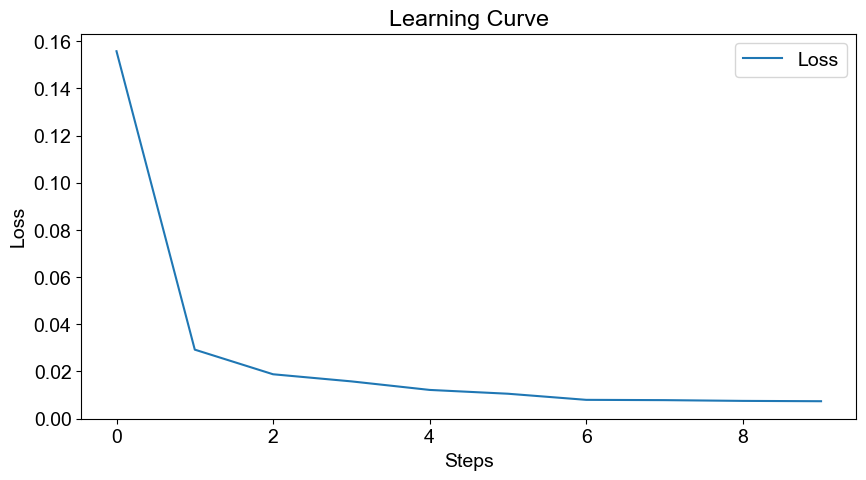

In [6]:
plt.rcParams.update({'font.size': 14})
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env = dataset.env
act_size = env.action_space.n
# Train network
rnnnet = RNNNet(input_size=env.observation_space.shape[0],
          hidden_size=64,
          output_size=act_size,dt=env.dt)
rnnnet = rnnnet.to(device)
print(rnnnet)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnnnet.parameters(), lr=0.001)

print('Training task ', task)
loss_values_lr = []  # List to store loss values
I_XT_list_lr = []
I_TY_list_lr = []
running_loss = 0.0
num_bins=30
for i in range(2000):
    inputs, labels_org = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels_org.flatten()).type(torch.long).to(device)
    labels_org = torch.from_numpy(labels_org)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = rnnnet(inputs)

    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        loss_values_lr.append(running_loss / 200)  # Append average loss her
        running_loss = 0.0
        torch.save(rnnnet.state_dict(), modelpath / 'leakyrnn_net.pth')

print('Finished Training')
# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values_lr, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

EI RNN train

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=2, out_features=64, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=51, out_features=3, bias=True)
)
Training task  DelayComparison-v0
200 loss: 0.15048
400 loss: 0.03661
600 loss: 0.02545
800 loss: 0.02071
1000 loss: 0.01850
1200 loss: 0.01684
1400 loss: 0.01638
1600 loss: 0.01467
1800 loss: 0.01399
2000 loss: 0.01295
Finished Training


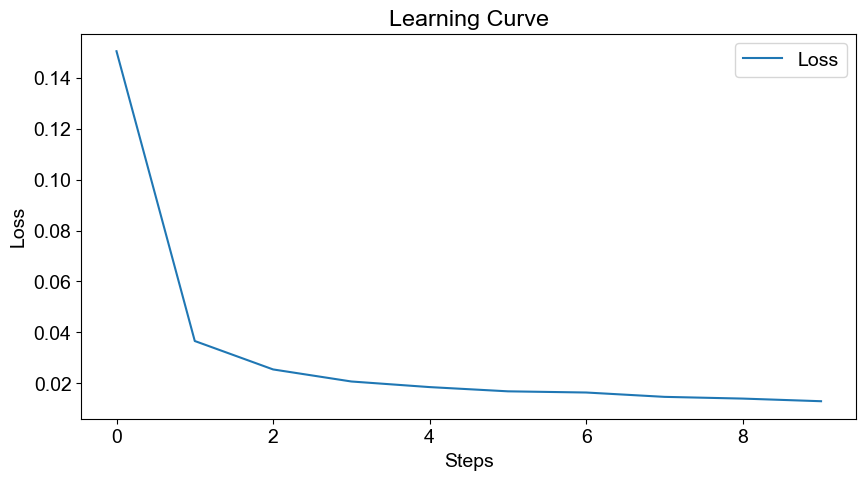

In [7]:
env = dataset.env
act_size = env.action_space.n
# Train network
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=64,
          output_size=act_size, dt=env.dt)
net = net.to(device)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print('Training task ', task)

loss_values = []  # List to store loss values
I_XT_list = []
I_TY_list = []
running_loss = 0.0
num_bins=30
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = net(inputs.to(device))

    loss = criterion(outputs.view(-1, act_size), labels.to(device))
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        loss_values.append(running_loss / 200)  # Append average loss here

        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'EIrnn_net.pth')
    # if i % 100 == 0:
    
    #     # 在每个epoch结束后，计算每个时间步的互信息
    #     net.eval()
    #     all_X = []
    #     all_T = []
    #     all_Y = []
    #     with torch.no_grad():
    #         X_batch = inputs.to(device)
    #         Y_batch = labels_org.to(device)
    #         outputs, hidden_states = net(X_batch)
    #         all_X.append(X_batch.cpu())
    #         all_T.append(hidden_states.cpu())
    #         all_Y.append(Y_batch.cpu())
    #         # torch.Size([1000, 100, 10]) torch.Size([1000, 100, 50]) torch.Size([1000, 100])
    #         all_X = torch.cat(all_X, dim=0)  # (num_samples, seq_length, input_size)
    #         all_T = torch.cat(all_T, dim=0)  # (num_samples, seq_length, hidden_size)
    #         all_Y = torch.cat(all_Y, dim=0)  # (num_samples, seq_length)
    
    #         all_X = all_X.permute(1, 0, 2)
    #         all_Y = all_Y.permute(1, 0)
    #         all_T = all_T.permute(1, 0, 2)
    #         # torch.Size([100, 16, 3]) torch.Size([100, 16]) torch.Size([100, 16, 50])
    #         # print(all_X.shape, all_Y.shape, all_T.shape)
    
    #         I_XT = compute_mutual_information(all_X, all_T, num_bins)
    #         I_TY = compute_mutual_information_TY(all_T, all_Y, num_bins)
    #         I_XT_list.append(I_XT)
    #         I_TY_list.append(I_TY)
print('Finished Training')
# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
# 设置delay为3000ms
# 重新生成任务环境
kwargs = {'timing': {'delay': ('constant', 3000)}}
env = gym.make(task, **kwargs)
env.reset(no_step=True)
env.timing

{'fixation': 500,
 'stimulus1': 500,
 'delay': ('constant', 3000),
 'stimulus2': 500,
 'decision': 100}

leaky rnn analysis

In [35]:
activity_dict_lrnn = {}
trial_infos_lrnn = {}
stim_activity_lrnn = [[], [], []]  # response for ground-truth 0 and 1
num_trial=500
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float).to(device)
    action_pred, rnn_activity = rnnnet(inputs)

    # Compute performance
    action_pred = action_pred.detach().cpu().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos_lrnn[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().cpu().numpy()
    # activity_dict_lrnn[i] = rnn_activity
    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['delay']: env.end_ind['delay']]
    activity_dict_lrnn[i] = rnn_activity
    stim_activity_lrnn[env.trial['ground_truth']].append(rnn_activity)
print('Average performance', np.mean([val['correct'] for val in trial_infos_lrnn.values()]))



Average performance 0.976


Shape of the neural activity (Time points, Neurons): (3000, 64)
Shape of the projected activity (Time points, PCs): (3000, 2)


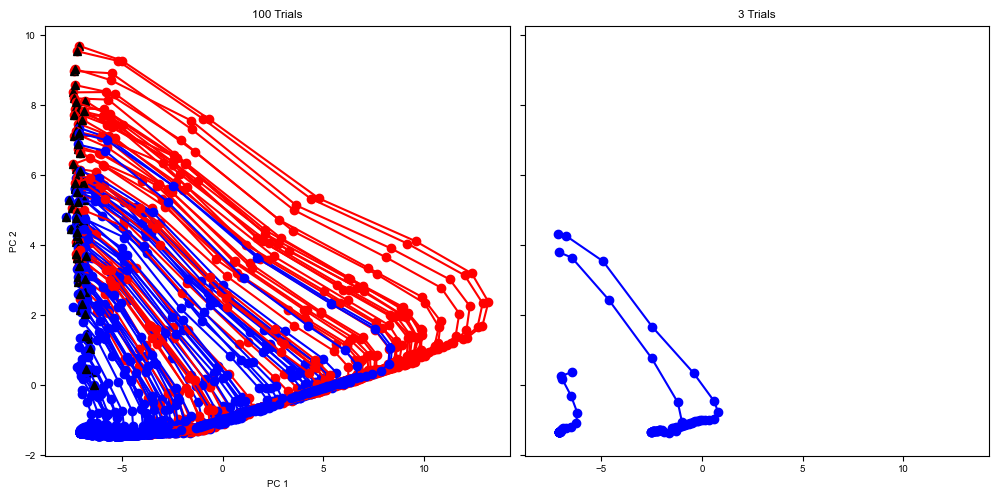

In [58]:
#leaky rnn Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 100  # Number of trials to analyse


# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict_lrnn[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca1 = PCA(n_components=2)  # Using 2 components for visualization
pca1.fit(activity)
activity_pc = pca1.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca1.transform(activity_dict_lrnn[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos_lrnn[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [10]:
# Here for each neuron we compute its stimulus period selectivity 为每个神经元计算其在刺激期的选择性

hidden_size = rnnnet.rnn.hidden_size #隐藏层神经元数量

mean_activity = []
std_activity = []
for ground_truth in [1, 2]:
    activity = np.concatenate(stim_activity_lrnn[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

ind_sort = np.argsort(selectivity[:])
                           

rnn.input2h.weight
rnn.input2h.bias
rnn.h2h.weight
rnn.h2h.bias
fc.weight
fc.bias


Text(0.5, 1.0, 'Network connectivity')

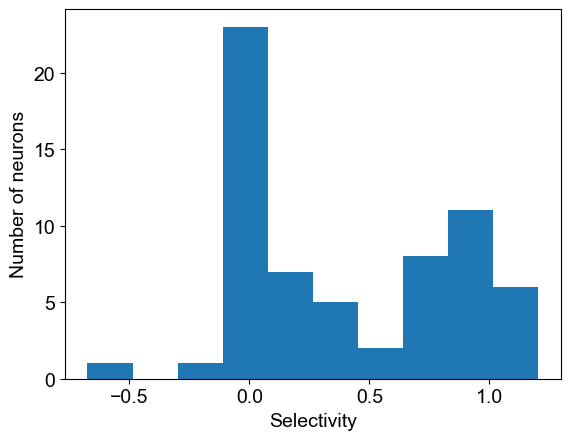

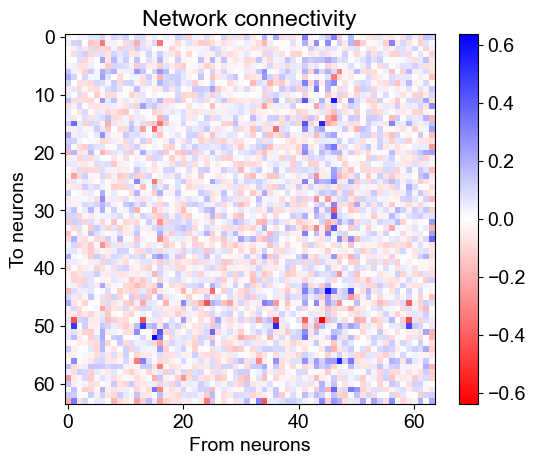

In [11]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
plt.rcParams.update({'font.size': 14})
# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

# W = rnnnet.rnn.h2h.effective_weight().detach().cpu().numpy()
# Sort by selectivity
for name, param in rnnnet.named_parameters():
    print(name)
    if 'rnn.h2h.weight' in name:
        W= param.data.detach().cpu().numpy()
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')


In [12]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2
print_step = 200
num_neurons_to_lesion = int(lesion_fraction * rnnnet.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(rnnnet, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        rnnnet.rnn.h2h.weight[selective_neurons, :] = 0
        rnnnet.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = rnnnet.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(rnnnet, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = rnnnet(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
rnnnet.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.1304


In [62]:
import sys
sys.path.append('/root/autodl-tmp/fixed-point-finder-master')
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

In [63]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [64]:
# Instantiate the FixedPointRNNWrapper with the leaky-RNN model from Net
leaky_rnn_model_fixed_point = FixedPointRNNWrapper(rnnnet.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder_lr = FixedPointFinder(leaky_rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions_lr = torch.randn(10, rnnnet.rnn.hidden_size)  # 10 random initial hidden states
inputs_lr = torch.zeros(10, rnnnet.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np_lr = initial_conditions_lr.cpu().numpy()
inputs_np_lr = inputs_lr.cpu().numpy()

# Run fixed-point finding using the wrapped model
leaky_rnn_fixed_points_result = finder_lr.find_fixed_points(initial_states=init_hidden_np_lr, inputs=inputs_np_lr)

# Unpack the returned tuple
fps_lr = leaky_rnn_fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points_lr = fps_lr.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 7.12e-11 +/- 1.76e-10
		dq = 2.25e-13 +/- 5.69e-13
		learning rate = 1.97e-07
		avg iter time = 2.87e-03 sec
	Identified 2 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 2).
	Computing recurrent Jacobian at 2 unique fixed points.
	Computing input Jacobian at 2 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



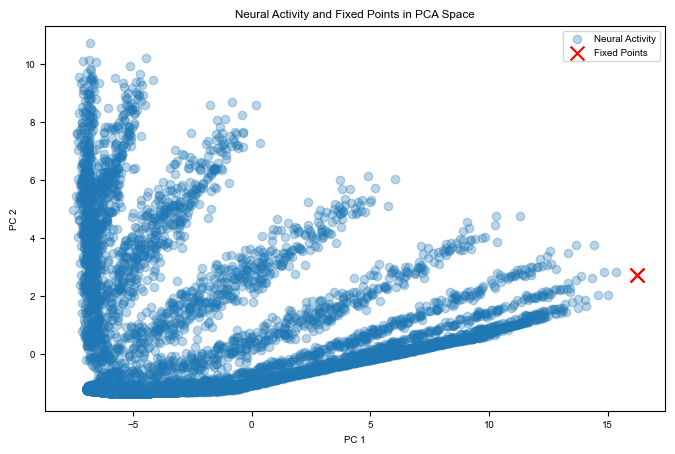

In [65]:
# Collect activity from all trials
activity_list_lrnn = []
for trial_activity in activity_dict_lrnn.values():
    activity_list_lrnn.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity_lrnn = np.vstack(activity_list_lrnn)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array_lr = np.vstack(fixed_points_lr)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp_lr = np.concatenate([activity_lrnn, fixed_points_array_lr], axis=0)
pca.fit(activity_and_fp_lr)

# Transform activity and fixed points
activity_pc_lr = pca.transform(activity_lrnn)
fixed_points_pc_lr = pca.transform(fixed_points_array_lr)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc_lr[:, 0], activity_pc_lr[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc_lr[:, 0], fixed_points_pc_lr[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()


In [31]:
# Define different constant inputs
input_values_lr = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input_lr = []

for input_val in input_values_lr:
    # Prepare constant input
    inputs_np_lr = np.full((10, rnnnet.rnn.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np_lr = initial_conditions_lr.cpu().numpy()

    # Find fixed points with the current input
    fps_result_lr = finder_lr.find_fixed_points(initial_states=init_hidden_np_lr, inputs=inputs_np_lr)
    fps_lr = fps_result_lr[0]
    fixed_points_by_input_lr.append((input_val, fps_lr.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values_lr)))
print()
for idx, (input_val, fp_array) in enumerate(fixed_points_by_input_lr):
    print(1)
    # Project fixed points into PCA space
    fp_pc_lr = pca.transform(fp_array)
    plt.scatter(fp_pc_lr[:, 0], fp_pc_lr[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 3.13e-10 +/- 5.64e-10
		dq = 4.55e-14 +/- 1.36e-13
		learning rate = 1.97e-07
		avg iter time = 2.93e-03 sec
	Identified 2 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 2 outliers detected (of 2).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.64e-10 +/- 2.38e-10
		dq = 6.82e-13 +/- 9.81e-13
		learning rate = 1.97e-07
		avg iter time = 2.95e-03 sec
	Identified 2 unique fixed points.
		initial_states: 0 o

TypeError: unsupported operand type(s) for -: 'enumerate' and 'int'

<Figure size 800x600 with 0 Axes>

In [66]:
# 冻结RNN里面的参数
for param in rnnnet.parameters():
    param.requires_grad = False

# 设定batch_size为1000
batch_size = 1000

# input为1000 * 1个[1, 0]，即input的shape为[1000, 2]
# 之所以为[1, 0]是因为在delay阶段，fixation维度始终为1，stimulus维度始终为0
input = np.tile([1, 0], (batch_size, 1))
# 转成torch格式
input = torch.tensor(input, dtype=torch.float32)

# 隐藏层活动作为变量进行优化
# 即输入不同的隐藏层活动作为动力学系统的起始点来找每条运动轨迹下的近似固定点
# 随机产生1000个隐藏层活动，这里的方法是：
# 随机抽取1000个隐藏层活动，即从activity的3000个时间点中抽取1000个
# hidden_init的shape为[1000, 64]
# 再对矩阵里的每一个值乘以一个0.5-1.5之间的随机数
hidden_init = activity_lrnn[np.random.randint(activity_lrnn.shape[0], size=(batch_size,))]
hidden_init = np.random.uniform(0.5, 1.5, size=hidden_init.shape) * hidden_init
hidden = torch.tensor(hidden_init, requires_grad=True, dtype=torch.float32)

# 使用Adam优化器
optimizer1 = torch.optim.Adam([hidden], lr=0.01)
criterion1 = nn.MSELoss()

# 初始化loss
running_loss = 0
# 进行1000次迭代
for i in range(10000):
    # 梯度初始化为0
    optimizer1.zero_grad()
    
    # 调用训练好RNN模型的recurrence方法得到新的隐藏层活动
    new_h = rnnnet.rnn.recurrence(input.to(device), hidden.to(device))
    # 计算前后两hidden之间的loss
    loss = criterion1(new_h.to(device), hidden.to(device))
    # 反向传播
    loss.backward()
    # 更新权重
    optimizer1.step()
    
    # 每1000步打印一次Loss
    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 0.0172
Step 2000, Loss 0.0002
Step 3000, Loss 0.0000
Step 4000, Loss 0.0000
Step 5000, Loss 0.0000
Step 6000, Loss 0.0000
Step 7000, Loss 0.0000
Step 8000, Loss 0.0000
Step 9000, Loss 0.0000
Step 10000, Loss 0.0000


Text(0, 0.5, 'PC 2')

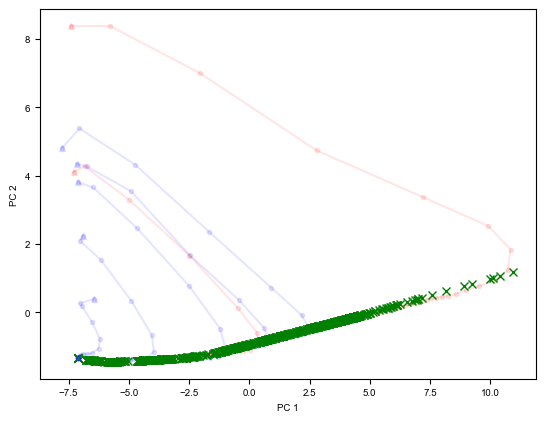

In [71]:
# 获取1000个64维的固定点
fixedpoints_lr = hidden.detach().numpy()

# 类似之前的操作，绘制前20个试次的delay阶段的2维PC空间表征
plt.figure()
for i in range(7):
    activity_pc_l = pca1.transform(activity_dict_lrnn[i])
    trial = trial_infos_lrnn[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    plt.plot(activity_pc_l[:, 0], activity_pc_l[:, 1], 'o-',
             color=color, ms=3, alpha=0.1)
    plt.plot(activity_pc_l[0, 0], activity_pc_l[0, 1], marker='^',
             color=color, ms=5, alpha=0.1)

# 绘制计算得到的200个固定点
fixedpoints_pc = pca1.transform(fixedpoints_lr)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', color='green')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [36]:
activity_dict = {}
trial_infos = {}  
stim_activity = [[], [], []]

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float).to(device)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().cpu().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().cpu().numpy()

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['delay']: env.end_ind['delay']]
    activity_dict[i] = rnn_activity
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))



Average performance 0.684


Shape of the neural activity (Time points, Neurons): (3000, 64)
Shape of the projected activity (Time points, PCs): (3000, 2)


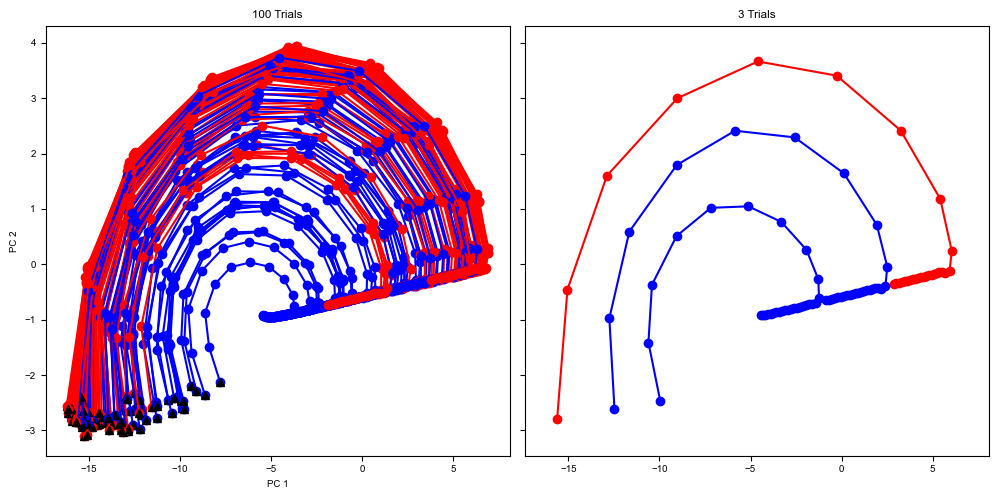

In [35]:
#ET rnn Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 100  # Number of trials to analyse

# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca1 = PCA(n_components=2)  # Using 2 components for visualization
pca1.fit(activity)
activity_pc = pca1.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca1.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [14]:
# Here for each neuron we compute its stimulus period selectivity 为每个神经元计算其在刺激期的选择性

e_size = net.rnn.e_size #EIRNN网络中兴奋神经元的数量

mean_activity = []
std_activity = []
for ground_truth in [1, 2]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

Text(0.5, 1.0, 'Network connectivity')

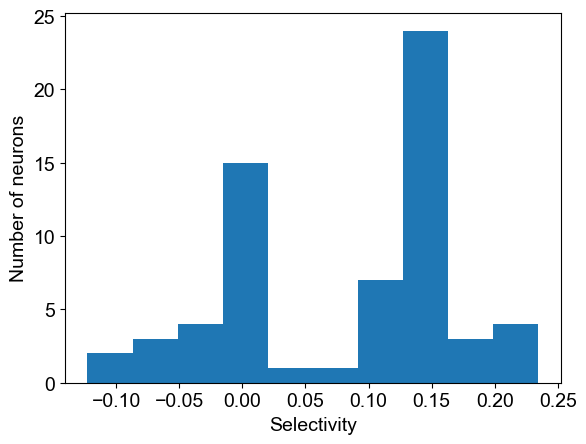

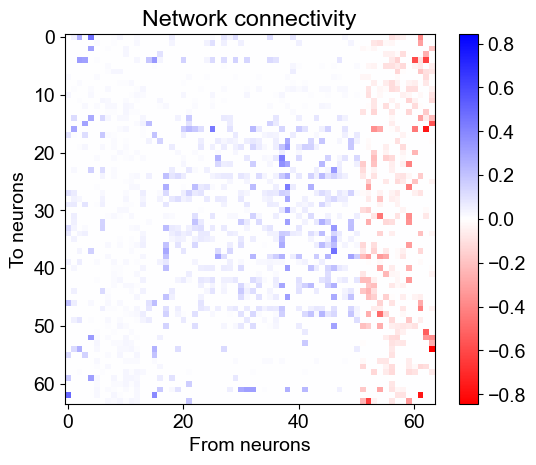

In [15]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().cpu().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

In [16]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)


Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.0441


In [39]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [40]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		922 iters
		q = 6.48e-01 +/- 1.03e-07
		dq = 0.00e+00 +/- 0.00e+00
		learning rate = 1.25e-06
		avg iter time = 3.34e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



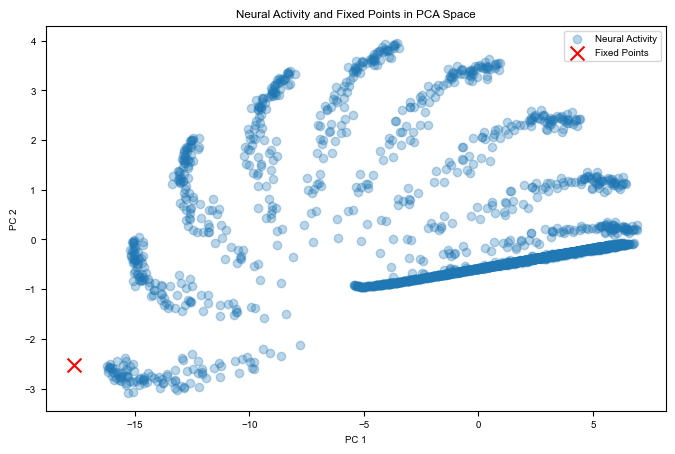

In [41]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		934 iters
		q = 4.85e+00 +/- 6.22e-07
		dq = 0.00e+00 +/- 0.00e+00
		learning rate = 7.48e-07
		avg iter time = 3.46e-03 sec
	Identified 3 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 3).
	Computing recurrent Jacobian at 3 unique fixed points.
	Computing input Jacobian at 3 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1133 iters
		q = 2.06e+00 +/- 2.78e-01
		dq = 0.00e+00 +/- 0.00e+00
		learning 

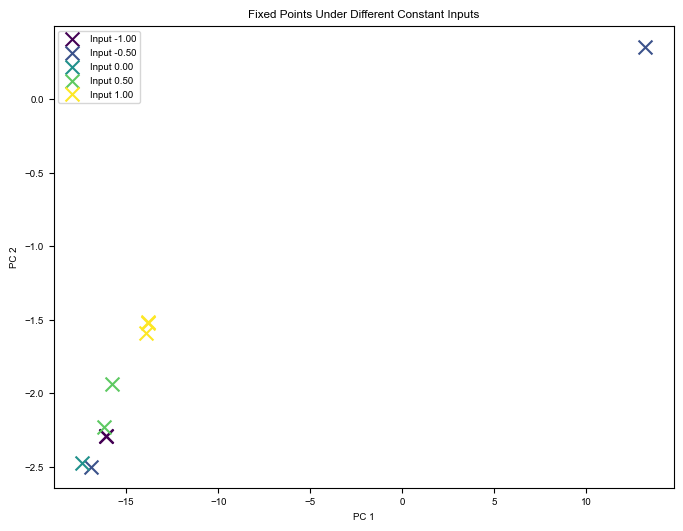

In [27]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, net.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


In [42]:
# 冻结RNN里面的参数
for param in net.parameters():
    param.requires_grad = False

# 设定batch_size为1000
batch_size = 1000

# input为1000 * 1个[1, 0]，即input的shape为[1000, 2]
# 之所以为[1, 0]是因为在delay阶段，fixation维度始终为1，stimulus维度始终为0
input = np.tile([1, 0], (batch_size, 1))
# 转成torch格式
input = torch.tensor(input, dtype=torch.float32)

# 隐藏层活动作为变量进行优化
# 即输入不同的隐藏层活动作为动力学系统的起始点来找每条运动轨迹下的近似固定点
# 随机产生1000个隐藏层活动，这里的方法是：
# 随机抽取1000个隐藏层活动，即从activity的3000个时间点中抽取1000个
# hidden_init的shape为[1000, 64]
# 再对矩阵里的每一个值乘以一个0.5-1.5之间的随机数
hidden_init = activity[np.random.randint(activity.shape[0], size=(batch_size,))]
hidden_init = np.random.uniform(0.5, 1.5, size=hidden_init.shape) * hidden_init
hidden = torch.tensor(hidden_init, requires_grad=True, dtype=torch.float32)

# 使用Adam优化器
optimizer1 = torch.optim.Adam([hidden], lr=0.01)
criterion1 = nn.MSELoss()

# 初始化loss
running_loss = 0
# 进行1000次迭代
for i in range(10000):
    # 梯度初始化为0
    optimizer1.zero_grad()
    
    # 调用训练好RNN模型的recurrence方法得到新的隐藏层活动
    new_h = net.rnn.recurrence(input.to(device), hidden.to(device))
    # 计算前后两hidden之间的loss
    loss = criterion1(new_h.to(device), hidden.to(device))
    # 反向传播
    loss.backward()
    # 更新权重
    optimizer1.step()
    
    # 每1000步打印一次Loss
    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 0.0432
Step 2000, Loss 0.0001
Step 3000, Loss 0.0000
Step 4000, Loss 0.0000
Step 5000, Loss 0.0000
Step 6000, Loss 0.0000
Step 7000, Loss 0.0000
Step 8000, Loss 0.0000
Step 9000, Loss 0.0000
Step 10000, Loss 0.0000


Text(0, 0.5, 'PC 2')

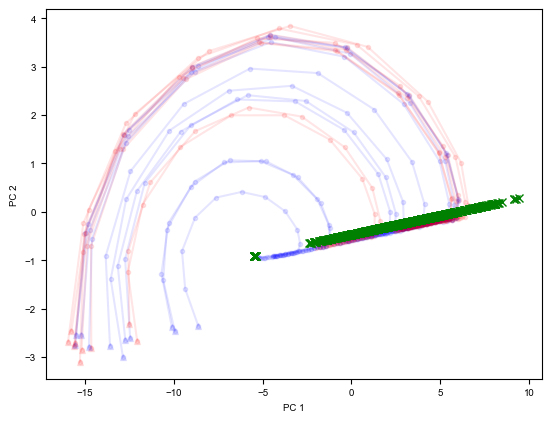

In [43]:
# 获取1000个64维的固定点
fixedpoints = hidden.detach().numpy()

# 类似之前的操作，绘制前20个试次的delay阶段的2维PC空间表征
plt.figure()
for i in range(20):
    activity_pc = pca1.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, ms=3, alpha=0.1)
    plt.plot(activity_pc[0, 0], activity_pc[0, 1], marker='^',
             color=color, ms=5, alpha=0.1)

# 绘制计算得到的200个固定点
fixedpoints_pc = pca1.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', color='green')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from tqdm import tqdm


# 计算互信息的函数
def compute_mutual_information(X, T, num_bins=30):
    """
    计算 I(X; T) 的近似值。

    参数：
    - X: 输入数据，形状为 (num_samples, seq_length, input_size)
    - T: 隐藏状态，形状为 (num_samples, seq_length, hidden_size)
    - num_bins: 用于离散化的bin数量
    """
    num_samples, seq_length, hidden_size = T.shape
    I_XT = []

    for t in range(seq_length):
        I_XT_t = 0
        # 获取第 t 个时间步的隐藏状态
        T_t = T[:, t, :]  # (num_samples, hidden_size)
        # 获取第 t 个时间步的输入
        X_t = X[:, :t+1, :]  # (num_samples, input_size)
        # print(X.shape,X_t.shape, X_t.shape[2]*X_t.shape[1])
        X_t = X_t.reshape(X_t.shape[0], X_t.shape[2]*X_t.shape[1])
        # print(X.shape,X_t.shape)
        for i in range(hidden_size):
            # 离散化隐藏状态的第 i 个神经元
            t_i = T_t[:, i].detach().cpu().numpy()
            t_bins = np.histogram_bin_edges(t_i, bins=num_bins)
            t_digitized = np.digitize(t_i, bins=t_bins)
            
            # 对于输入的每个维度，同样离散化
            mutual_info = 0
            for j in range(X_t.shape[1]):
                x_j = X_t[:, j].detach().cpu().numpy()
                x_bins = np.histogram_bin_edges(x_j, bins=num_bins)
                x_digitized = np.digitize(x_j, bins=x_bins)
                
                # 计算联合概率分布和边缘概率分布
                joint_hist, _, _ = np.histogram2d(x_digitized, t_digitized, bins=num_bins)
                joint_prob = joint_hist / num_samples
                x_marginal = np.sum(joint_prob, axis=1)
                t_marginal = np.sum(joint_prob, axis=0)
                
                # 计算互信息
                joint_prob += 1e-12
                x_marginal += 1e-12
                t_marginal += 1e-12
                mi = np.sum(joint_prob * (np.log(joint_prob) - np.log(np.outer(x_marginal, t_marginal))))
                mutual_info += mi
            # 取输入维度的平均互信息
            mutual_info /= X_t.shape[1]
            I_XT_t += mutual_info
        # 取隐藏维度的平均互信息
        I_XT_t /= hidden_size
        I_XT.append(I_XT_t)
    return I_XT  # 返回每个时间步的 I(X; T_t)

def compute_mutual_information_TY(T, Y, num_bins=30):
    """
    计算 I(T; Y) 的近似值。

    参数：
    - T: 隐藏状态，形状为 (num_samples, seq_length, hidden_size)
    - Y: 标签，形状为 (num_samples, seq_length)
    - num_bins: 用于离散化的bin数量
    """
    num_samples, seq_length, hidden_size = T.shape
    I_TY = []
    print('seq_length', seq_length)

    for t in range(seq_length):
        I_TY_t = 0
        # 获取第 t 个时间步的隐藏状态
        T_t = T[:, t, :]  # (num_samples, hidden_size)
        # 获取第 t 个时间步的标签
        Y_t = Y[:, t]  # (num_samples,)
        unique_Y = np.unique(Y_t.detach().cpu().numpy())
        num_classes = unique_Y.size
        for i in range(hidden_size):
            # 离散化隐藏状态的第 i 个神经元
            t_i = T_t[:, i].detach().cpu().numpy()
            t_bins = np.histogram_bin_edges(t_i, bins=num_bins)
            t_digitized = np.digitize(t_i, bins=t_bins)
            
            y = Y_t.detach().cpu().numpy()
            # 计算联合概率分布和边缘概率分布
            joint_hist, _, _ = np.histogram2d(t_digitized, y, bins=[num_bins, num_classes])
            joint_prob = joint_hist / num_samples
            t_marginal = np.sum(joint_prob, axis=1)
            y_marginal = np.sum(joint_prob, axis=0)
            
            # 计算互信息
            joint_prob += 1e-12
            t_marginal += 1e-12
            y_marginal += 1e-12
            mi = np.sum(joint_prob * (np.log(joint_prob) - np.log(np.outer(t_marginal, y_marginal))))
            I_TY_t += mi
        # 取隐藏维度的平均互信息
        I_TY_t /= hidden_size
        I_TY.append(I_TY_t)
    return I_TY  # 返回每个时间步的 I(T_t; Y_t)

# 示例训练过程，计算每个时间步的 I(X; T_t) 和 I(T_t; Y_t)
def train_and_compute_information(net, dataloader, criterion, optimizer, epochs, num_bins=30):
    """
    在训练过程中，每个epoch结束后，计算每个时间步的互信息。

    返回：
    - I_XT_list: 列表，包含每个epoch的 I(X; T_t)
    - I_TY_list: 列表，包含每个epoch的 I(T_t; Y_t)
    """
    I_XT_list = []
    I_TY_list = []
    
    for epoch in tqdm(range(epochs), desc="Training"):
        net.train()
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optimizer.zero_grad()
            outputs, hidden_states = net(X_batch)
            # 将 outputs 变形为 (batch_size * seq_length, output_size)
            outputs = outputs.reshape(-1, outputs.size(-1))
            Y_batch = Y_batch.reshape(-1)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
        
        # 在每个epoch结束后，计算每个时间步的互信息
        net.eval()
        all_X = []
        all_T = []
        all_Y = []
        with torch.no_grad():
            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                outputs, hidden_states = net(X_batch)
                all_X.append(X_batch.cpu())
                all_T.append(hidden_states.cpu())
                all_Y.append(Y_batch.cpu())
            all_X = torch.cat(all_X, dim=0)  # (num_samples, seq_length, input_size)
            all_T = torch.cat(all_T, dim=0)  # (num_samples, seq_length, hidden_size)
            all_Y = torch.cat(all_Y, dim=0)  # (num_samples, seq_length)

            print(all_X.shape, all_T.shape, all_Y.shape)
            
            I_XT = compute_mutual_information(all_X, all_T, num_bins)
            I_TY = compute_mutual_information_TY(all_T, all_Y, num_bins)
            I_XT_list.append(I_XT)
            I_TY_list.append(I_TY)
    
    return I_XT_list, I_TY_list
